Install packages

In [32]:
!pip install pandas numpy tensorflow matplotlib keras_tuner


Import packages

In [33]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
import keras_tuner as kt


In [34]:
# Mount Google Drive (run once per Colab session to access/save files on Drive)
from google.colab import drive

# This opens an authorization flow; after approval, Drive is mounted at /content/drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load saved model to continue progress

In [35]:
# Project root: locate your Drive folder that may be named "MyDrive" or "My Drive"
#    (Google occasionally uses either spelling). The script picks the first that exists.
from pathlib import Path
candidates = [Path("/content/drive/MyDrive/lo"), Path("/content/drive/My Drive/lo")]
PROJECT_ROOT = next((p for p in candidates if p.exists()), None)
assert PROJECT_ROOT is not None, "Couldn't find your 'lo' folder in Drive."

# Build canonical paths for saved artifacts
MODEL_DIR = PROJECT_ROOT / "models"
MODEL_PATH = MODEL_DIR / "best_model.keras"                 # Keras model (architecture+weights)
BEST_RESULT_PATH = MODEL_DIR / "tuning_best_result.joblib"  # dict of best params/score
LEADERBOARD_PATH = MODEL_DIR / "tuning_leaderboard.joblib"  # list of all trials

# Sanity checks to prevent silent failures
assert MODEL_PATH.exists(), f"Missing model: {MODEL_PATH}"
print("Loading from:", MODEL_DIR)

# Load model and tuning artifacts
import tensorflow as tf, joblib
custom_objects = {}  # add custom layers/metrics here if you used any

model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)
best_result = joblib.load(BEST_RESULT_PATH) if BEST_RESULT_PATH.exists() else None
leaderboard = joblib.load(LEADERBOARD_PATH) if LEADERBOARD_PATH.exists() else None

# Quick verification: model topology and which tuning files were found
model.summary()
print("best_result:", "LOADED" if best_result is not None else "MISSING")
print("leaderboard:", "LOADED" if leaderboard is not None else "MISSING")



Loading from: /content/drive/MyDrive/lo/models


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,040,028 (57.37 MB)

 Trainable params: 5,011,678 (19.12 MB)

 Non-trainable params: 4,992 (19.50 KB)

 Optimizer params: 10,023,358 (38.24 MB)

best_result: LOADED
leaderboard: LOADED


Model performance visualization

Found history.json files: ['/content/drive/MyDrive/lo/models/history.json']
Found CSV logs: []
Using history file: /content/drive/MyDrive/lo/models/history.json


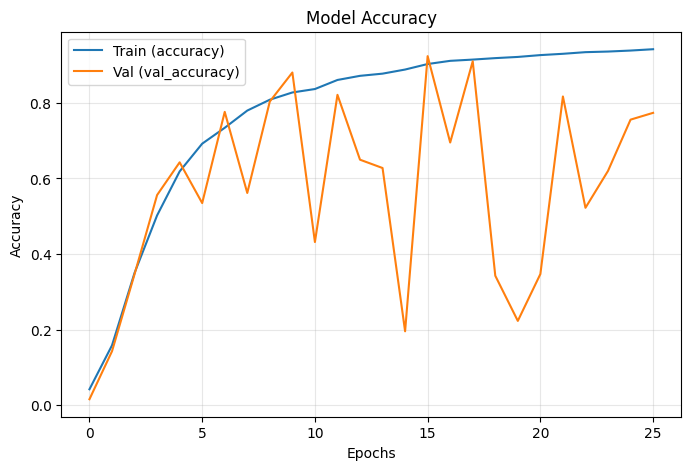

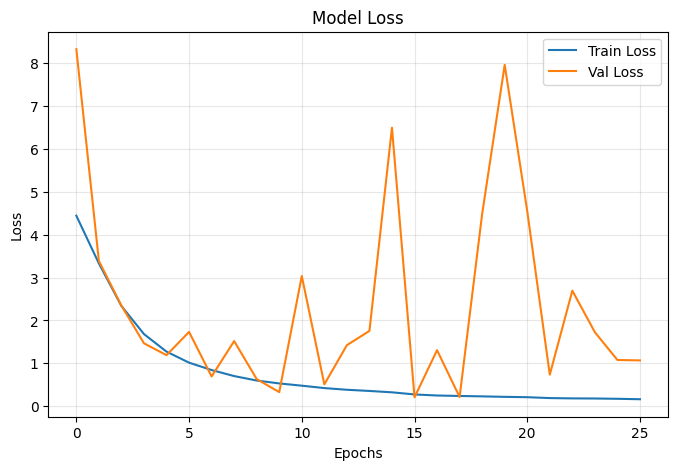

In [56]:
from pathlib import Path
import glob, json
import pandas as pd
import matplotlib.pyplot as plt

# --- Locate your project folder on Google Drive --------------------------------
# Support both "MyDrive" and "My Drive" variants to be robust across environments
# (Google Drive can mount with either path depending on Colab / OS quirks).
BASES = [Path("/content/drive/MyDrive/lo"), Path("/content/drive/My Drive/lo")]
PROJECT_ROOT = next((b for b in BASES if b.exists()), None)
assert PROJECT_ROOT is not None, "Can't find your 'lo' folder in Drive."

# --- Discover saved training logs anywhere under the project -------------------
# We scan recursively so you can keep runs in subfolders like lo/models/run_001/.
# history*.json       : saved via json.dump(history.history, f)
# *training_log*.csv  : produced by tf.keras.callbacks.CSVLogger(...)
hist_jsons = glob.glob(str(PROJECT_ROOT / "**" / "history*.json"), recursive=True)
csv_logs   = glob.glob(str(PROJECT_ROOT / "**" / "*training_log*.csv"), recursive=True)

print("Found history.json files:", hist_jsons)
print("Found CSV logs:", csv_logs)

if hist_jsons:
    # If multiple JSONs exist, pick the shortest path as a simple heuristic
    # (often the "main" run lives closer to the root). Adjust as needed.
    hpath = sorted(hist_jsons, key=len)[0]
    with open(hpath, "r") as f:
        hist = json.load(f)
    print("Using history file:", hpath)

    # Helper to robustly resolve metric names across different Keras configs.
    # Some environments log 'acc' vs 'accuracy', or sparse/binary variants.
    def get_key(d, *cands):
        for k in cands:
            if k in d: return k
        # If none matched, fail fast with a helpful message listing available keys.
        raise KeyError(f"Missing keys {cands}. Available: {list(d.keys())}")

    # Resolve metric names (train and validation accuracy).
    # This avoids KeyErrors when switching between losses/outputs.
    acc_k     = get_key(hist, "accuracy", "acc", "binary_accuracy", "sparse_categorical_accuracy")
    val_acc_k = get_key(hist, "val_accuracy", "val_acc", "val_binary_accuracy", "val_sparse_categorical_accuracy")

    # --- Plot Accuracy ----------------------------------------------------------
    # The two curves should ideally converge; persistent gap may indicate overfitting.
    plt.figure(figsize=(8,5))
    plt.plot(hist[acc_k],     label=f"Train ({acc_k})")
    plt.plot(hist[val_acc_k], label=f"Val ({val_acc_k})")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- Plot Loss --------------------------------------------------------------
    # Look for smooth downward trends; noisy or diverging validation loss is a red flag.
    plt.figure(figsize=(8,5))
    plt.plot(hist["loss"],     label="Train Loss")
    plt.plot(hist["val_loss"], label="Val Loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

elif csv_logs:
    # Fallback path when JSON is unavailable.
    # CSVLogger columns typically include: epoch, accuracy/acc, loss, val_accuracy/val_acc, val_loss.
    cpath = sorted(csv_logs, key=len)[0]
    log = pd.read_csv(cpath)
    print("Using CSV log:", cpath)

    # Resolve column names for train/val accuracy across common variants.
    # 'next' will raise StopIteration with a clear error if neither variant is found.
    acc_k     = next(c for c in ["accuracy","acc","binary_accuracy","sparse_categorical_accuracy"] if c in log.columns)
    val_acc_k = next(c for c in ["val_accuracy","val_acc","val_binary_accuracy","val_sparse_categorical_accuracy"] if c in log.columns)

    # --- Plot Accuracy ----------------------------------------------------------
    plt.figure(figsize=(8,5))
    plt.plot(log[acc_k],     label="Train")
    plt.plot(log[val_acc_k], label="Val")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- Plot Loss --------------------------------------------------------------
    # Loss columns are standardized by CSVLogger; if missing, inspect log.columns.
    plt.figure(figsize=(8,5))
    plt.plot(log["loss"],     label="Train Loss")
    plt.plot(log["val_loss"], label="Val Loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("No saved training logs found (no history*.json or *training_log*.csv). See below for a fallback and how to save next time.")


Prediction visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


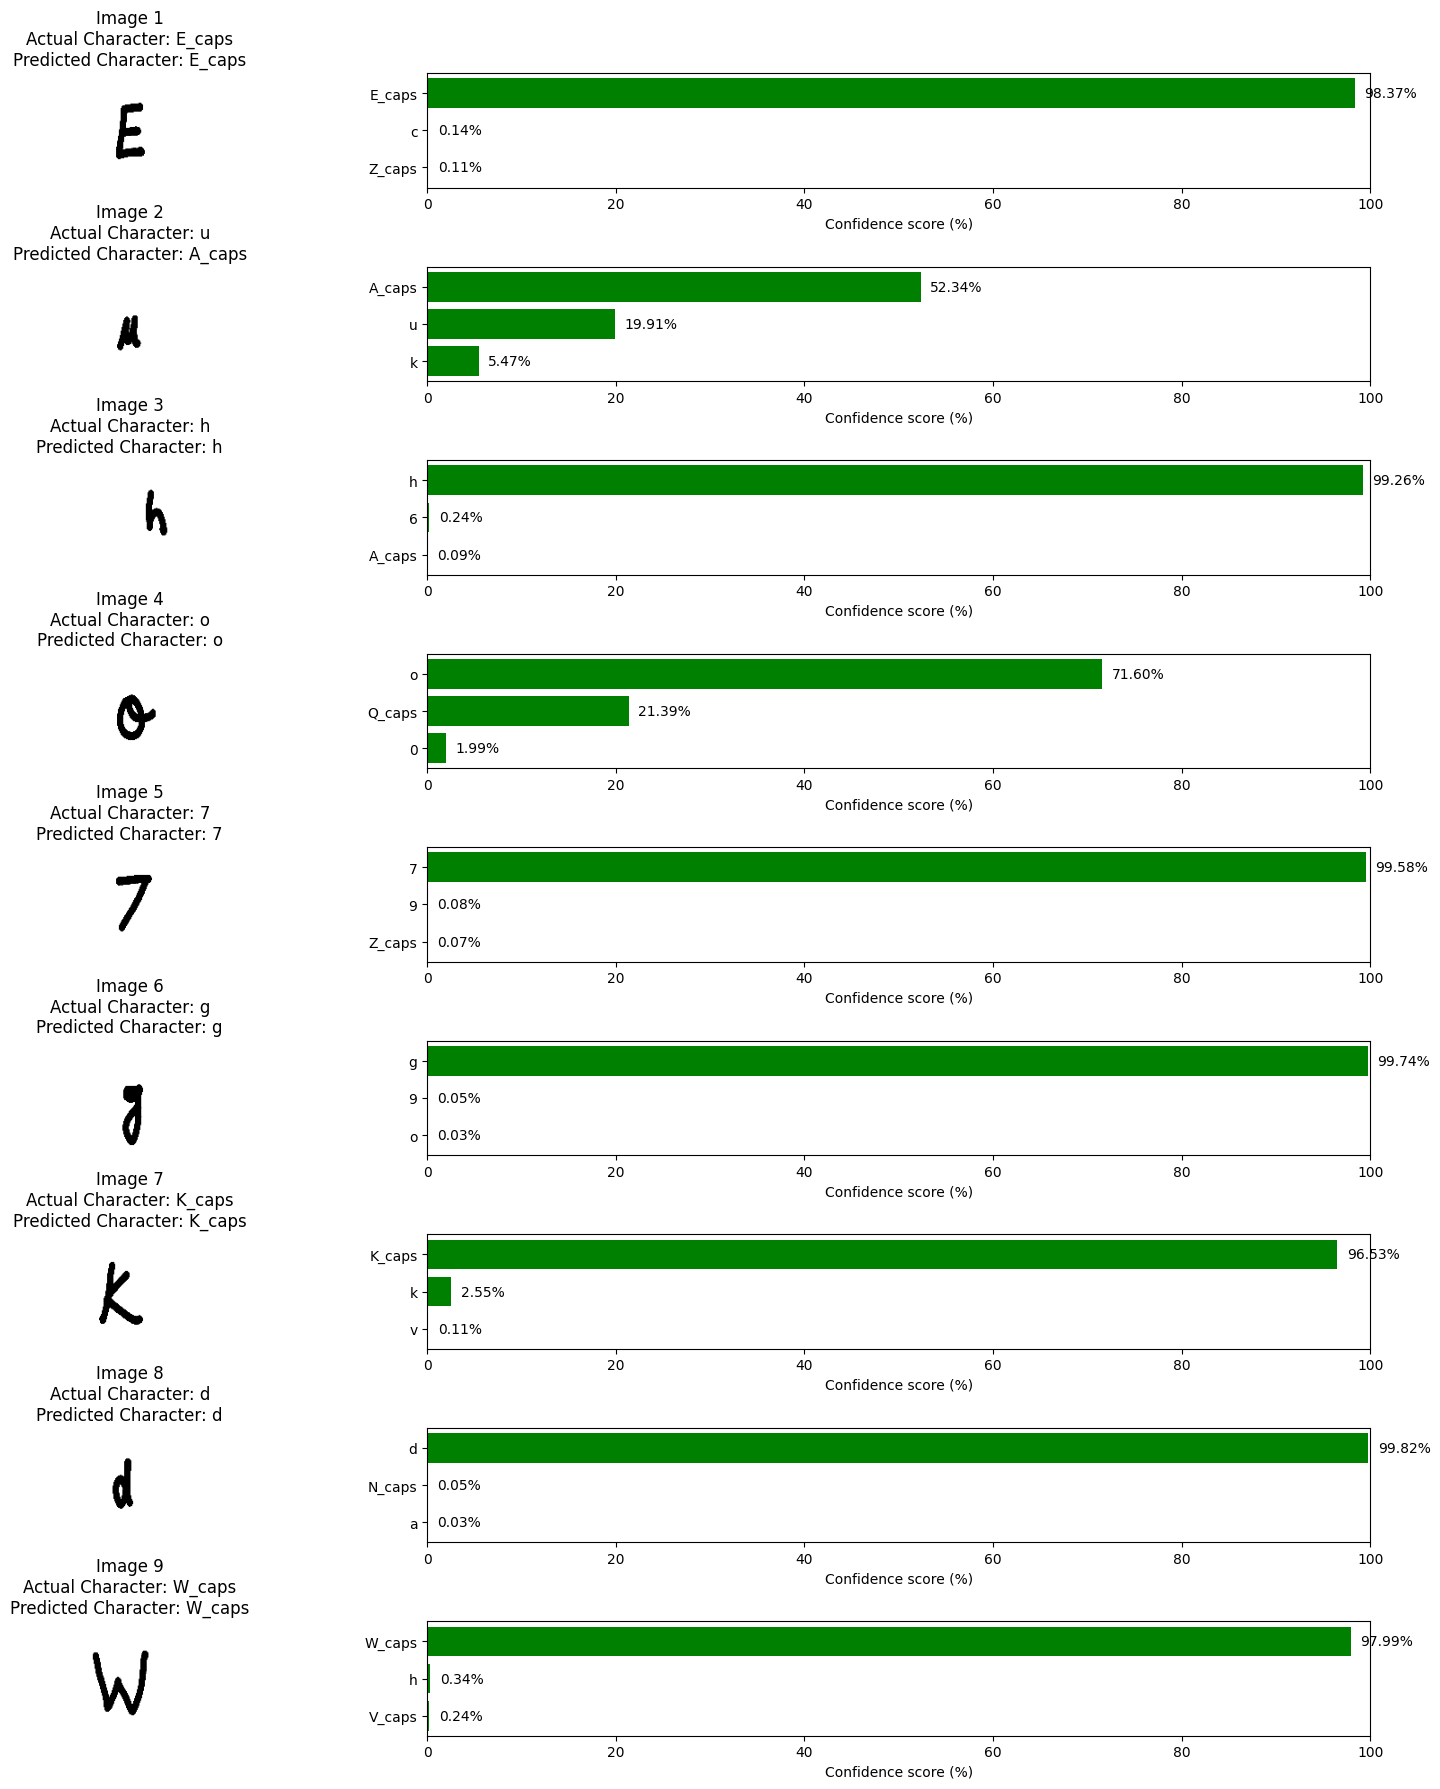

In [57]:
# Get class names
# Prefer names from the dataset object; if unavailable, fall back to numeric strings (0..61).
class_names = test_ds.class_names if hasattr(test_ds, 'class_names') else [str(i) for i in range(62)]

# Take one batch from the test dataset (doesn't iterate over the whole set).
for images, labels in test_ds.take(1):
    # Forward pass to obtain per-class scores/probabilities for this batch
    preds = model.predict(images)

    # Convert predicted probabilities/scores to class indices (argmax across classes)
    pred_classes = np.argmax(preds, axis=1)

    # Convert true labels to integer indices:
    # - If labels are one-hot (2D), take argmax.
    # - If labels are already integer-encoded (1D), just convert to numpy.
    if labels.ndim > 1:
        true_classes = np.argmax(labels.numpy(), axis=1)
    else:
        true_classes = labels.numpy()

    # Visualise 9 samples: left = image + predicted/true label, right = top-3 probability bars
    plt.figure(figsize=(18, 18))
    for i in range(9):
        # -------- Image Plot --------
        # Use odd-numbered subplot positions for images (1, 3, 5, ...).
        plt.subplot(9, 2, 2*i + 1)
        # Ensure pixel dtype is uint8 for correct imshow rendering (avoid float [0,1] scaling confusion).
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(
            f"Image {i+1}\n"
            f"Actual Character: {class_names[int(true_classes[i])]}\n"
            f"Predicted Character: {class_names[int(pred_classes[i])]}"
        )

        # -------- Probability Bar Plot --------
        # Get indices of top-3 classes for this sample, sorted by descending score.
        top3_idx = np.argsort(preds[i])[-3:][::-1]
        top3_probs = preds[i][top3_idx]                  # Corresponding probabilities/scores
        top3_labels = [class_names[j] for j in top3_idx] # Map indices -> human-readable labels

        # Use even-numbered subplot positions for bar charts (2, 4, 6, ...).
        plt.subplot(9, 2, 2*i + 2)
        # Horizontal bars: easier to read class names and add value annotations.
        bars = plt.barh(top3_labels, top3_probs * 100, color='green')
        plt.xlim(0, 100)
        plt.xlabel("Confidence score (%)")
        # Put the highest-probability class at the top of the chart.
        plt.gca().invert_yaxis()

        # Annotate each bar with its percentage (two decimals).
        for bar in bars:
            width = bar.get_width()
            plt.text(
                width + 1,  # a little to the right of the bar
                bar.get_y() + bar.get_height()/2,
                f"{width:.2f}%",
                va='center'
            )

    plt.tight_layout()
    plt.show()


Import datasets needed

In [38]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaymann/handwritten-english-characters-and-digits")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'handwritten-english-characters-and-digits' dataset.
Path to dataset files: /kaggle/input/handwritten-english-characters-and-digits


In [39]:
import os
print("Files in dataset folder:")
print(os.listdir(path))

Files in dataset folder:
['handwritten-english-characters-and-digits', 'image_labels.csv', 'augmented_images']


In [40]:
train_dir = os.path.join(path, "handwritten-english-characters-and-digits/combined_folder/train") #'/kaggle/input/handwritten-english-characters-and-digits/handwritten-english-characters-and-digits/combined_folder/train'
test_dir  = os.path.join(path, "handwritten-english-characters-and-digits/combined_folder/test") #'/kaggle/input/handwritten-english-characters-and-digits/handwritten-english-characters-and-digits/combined_folder/test'
augmented_data= os.path.join(path, "augmented_images/augmented_images1") #'/kaggle/input/handwritten-english-characters-and-digits/augmented_images/augmented_images1'

In [41]:
test_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(128,128),
    batch_size=32,
    label_mode='categorical'
)

Found 682 files belonging to 62 classes.


In [59]:
def collect_preds(model, ds):
    y_true, y_prob = [], []

    # Iterate batches from the dataset.
    # IMPORTANT: for evaluation, ensure ds is built with shuffle=False and WITHOUT augmentation.
    for xb, yb in ds:
        # Forward pass (suppress verbose per-batch logs)
        pb = model.predict(xb, verbose=0)

        # --- Normalize model outputs to proper probabilities -------------------
        # If model produced a 1D array, assume binary classification with p(class1).
        # Convert to two columns: [p(class0), p(class1)].
        if pb.ndim == 1:                           # e.g., shape [batch]
            pb = np.stack([1.0 - pb, pb], axis=1) # -> shape [batch, 2]
        # If any value is negative, we heuristically treat outputs as logits and
        # apply softmax to get probabilities. (Covers multi-class w/ logits.)
        elif pb.min() < 0:                         # indicates logits
            pb = tf.nn.softmax(pb, axis=1).numpy()

        # Accumulate per-batch probabilities
        y_prob.append(pb)

        # --- Normalize labels to integer class ids -----------------------------
        # Convert TF tensor -> numpy (safe if already numpy).
        yb = yb.numpy() if tf.is_tensor(yb) else np.asarray(yb)

        # If labels are one-hot (2D with last dim > 1), take argmax along classes.
        if yb.ndim > 1 and yb.shape[-1] > 1:
            y_true.append(np.argmax(yb, axis=1))
        else:
            # Otherwise assume integer labels (possibly shape [batch, 1]) and flatten.
            y_true.append(yb.reshape(-1))

    # --- Stitch all batches into single arrays ---------------------------------
    y_true = np.concatenate(y_true).astype(int)   # [N]
    y_prob = np.concatenate(y_prob)               # [N, C]
    y_pred = y_prob.argmax(axis=1)                # [N] via argmax over classes

    return y_true, y_pred, y_prob


# Build y_true, y_pred, y_prob.
# Make sure `test_ds` was created with shuffle=False and without any augmentation/transforms.
y_true, y_pred, y_prob = collect_preds(model, test_ds)



Confidence distribution

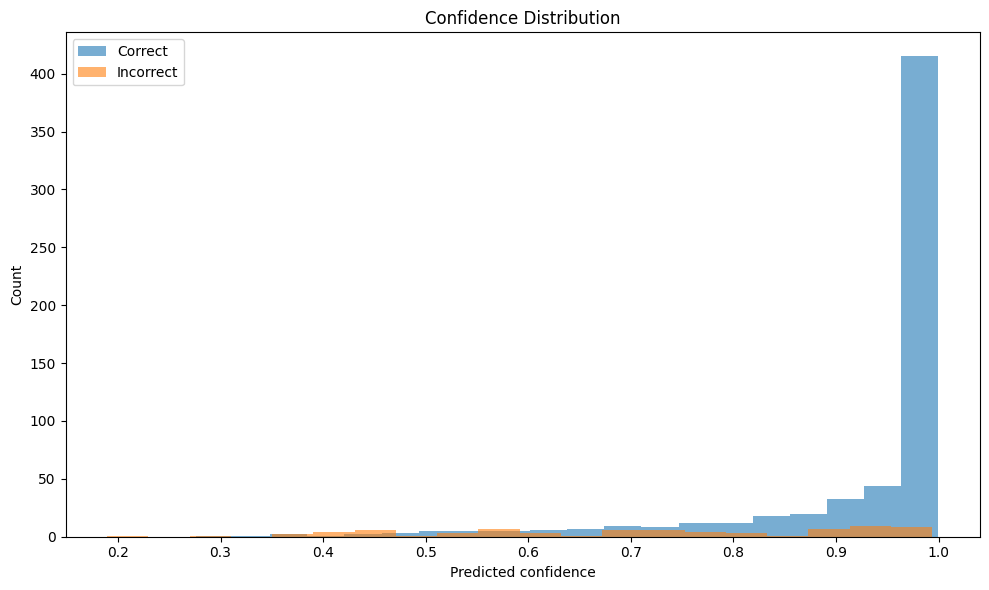

In [60]:
# Compute each prediction’s confidence as the max class probability (in [0,1]).
conf = y_prob.max(axis=1)

# Boolean mask: True if the predicted class equals the true class.
correct = (y_pred == y_true)

plt.figure(figsize=(10, 6))

# Histogram of confidences for correctly classified samples.
# alpha<1 makes bars semi-transparent so the two histograms can overlap visibly.
plt.hist(conf[correct], bins=20, alpha=0.6, label="Correct")

# Histogram of confidences for misclassified samples (should skew lower if model is well-calibrated).
plt.hist(conf[~correct], bins=20, alpha=0.6, label="Incorrect")

# Axis labels and title for interpretability.
plt.xlabel("Predicted confidence")
plt.ylabel("Count")
plt.title("Confidence Distribution")

# Show legend and tidy the layout to avoid clipping labels.
plt.legend()
plt.tight_layout()
plt.show()




Misclassified samples

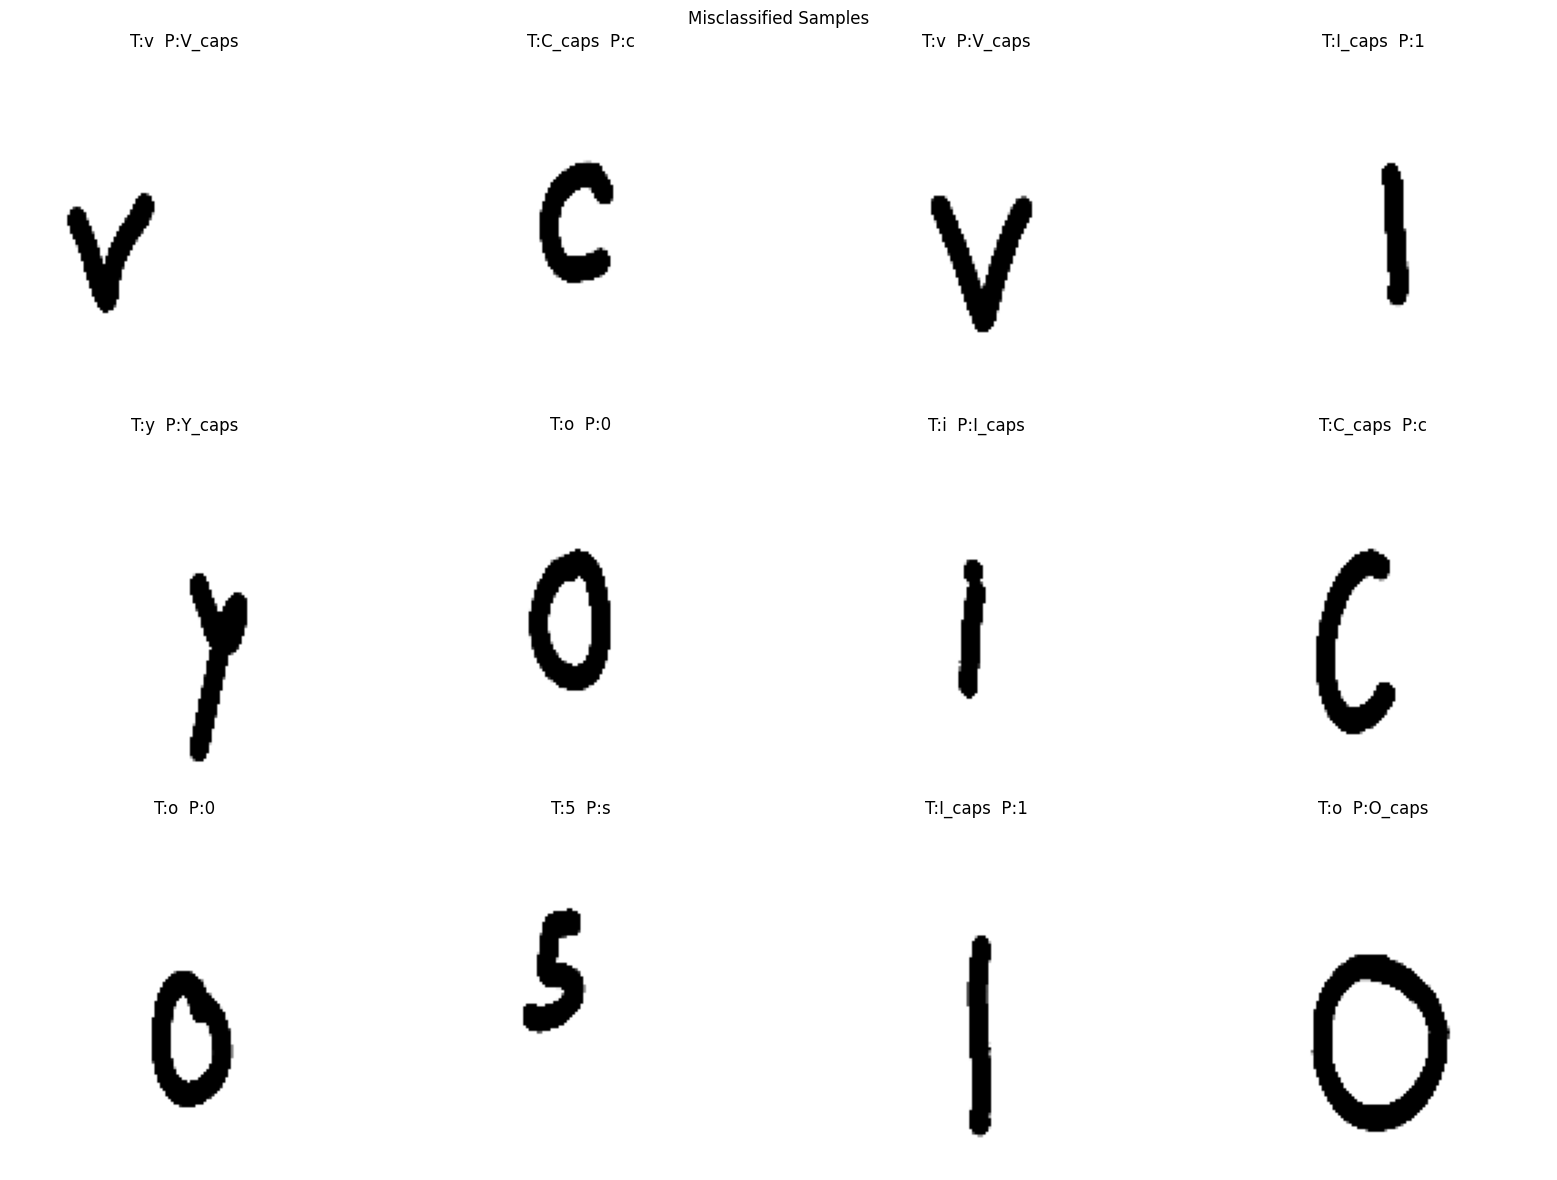

In [61]:
# Collect a small sample of misclassified images from the dataset
wrong_imgs, wrong_true, wrong_pred = [], [], []

# Iterate over the first ~50 batches to find mistakes (tweak 50 depending on dataset size/perf).
for x, y in test_ds.take(50):
    # Forward pass to get per-class scores/probabilities for this batch
    p = model.predict(x, verbose=0)

    # --- Normalize outputs to probabilities -----------------------------------
    # Binary case: a 1D vector of p(class1); expand to two columns [p(class0), p(class1)].
    if p.ndim == 1:
        p = np.stack([1 - p, p], axis=1)

    # Predicted class indices via argmax
    yp = p.argmax(axis=1)

    # --- Normalize ground-truth labels to integer ids --------------------------
    y_np = y.numpy() if tf.is_tensor(y) else y
    # If labels are one-hot (2D with last dim>1), take argmax; else flatten to 1D int array.
    yt = np.argmax(y_np, axis=1) if (y_np.ndim > 1 and y_np.shape[-1] > 1) else y_np.reshape(-1)

    # Boolean mask of misclassified samples in this batch
    mis = (yp != yt)

    # If any mistakes exist in this batch, stash the corresponding images/labels/preds
    if mis.any():
        wrong_imgs.append(x.numpy()[mis])
        wrong_true.append(yt[mis])
        wrong_pred.append(yp[mis])

    # Stop once we have collected at least 12 mistakes (enough for a 3x4 grid)
    if sum(map(len, wrong_true)) >= 12:
        break

# If we found any mistakes, visualize up to 12 of them in a grid
if wrong_imgs:
    # Concatenate across batches and clip to the first 12 samples for display
    wrong_imgs = np.concatenate(wrong_imgs)[:12]
    wrong_true = np.concatenate(wrong_true)[:12]
    wrong_pred = np.concatenate(wrong_pred)[:12]

    import matplotlib.pyplot as plt
    cols = 4
    rows = int(np.ceil(len(wrong_imgs) / cols))
    plt.figure(figsize=(4 * cols, 4 * rows))

    for i in range(len(wrong_imgs)):
        plt.subplot(rows, cols, i + 1)
        img = wrong_imgs[i]

        # If images are normalized to [0,1], rescale to uint8 for correct display
        if img.max() <= 1.0:
            img = (img * 255).clip(0, 255).astype('uint8')

        # Show image and annotate with True/Predicted labels
        plt.imshow(img.astype('uint8'))
        plt.axis('off')
        t = class_names[int(wrong_true[i])]
        p = class_names[int(wrong_pred[i])]
        plt.title(f"T:{t}  P:{p}")

    plt.suptitle("Misclassified Samples")
    plt.tight_layout()
    plt.show()


Most confused pairs

In [62]:
# Number of classes inferred from the probability matrix shape [N, C]
n_classes = y_prob.shape[1]

# Confusion matrix with an explicit, fixed label order 0..C-1.
# Using labels=np.arange(n_classes) ensures the matrix is CxC even if some classes
# were never predicted or never appeared in y_true.
cm = confusion_matrix(
    y_true,
    y_pred,
    labels=np.arange(n_classes)
)

# cm_norm = cm / cm.sum(axis=1, keepdims=True)


In [63]:
# Work on a copy so we don't mutate the original confusion matrix
cm_off = cm.copy()

# Zero-out the diagonal so we focus only on misclassifications (off-diagonal cells)
np.fill_diagonal(cm_off, 0)

# Flatten the matrix to 1D, get indices that would sort counts descending
flat_idx = np.argsort(cm_off.ravel())[::-1]

# Convert flattened indices back to (row, col) positions in the matrix
rows, cols = np.unravel_index(flat_idx, cm_off.shape)

top = 10  # how many highest-count confusions to display

print("Most-confused pairs (True → Pred, count):")
for r, c in zip(rows[:top], cols[:top]):
    # Early stop once remaining entries are zero (no more confusions)
    if cm_off[r, c] == 0:
        break
    # Map row/col indices to human-readable class names
    print(f"{class_names[r]} → {class_names[c]} : {cm_off[r, c]}")




Most-confused pairs (True → Pred, count):
v → V_caps : 5
p → P_caps : 4
I_caps → 1 : 4
0 → O_caps : 4
x → X_caps : 4
l → 1 : 4
o → O_caps : 4
C_caps → c : 3
o → 0 : 3
w → W_caps : 2


Top-k accuracy curves

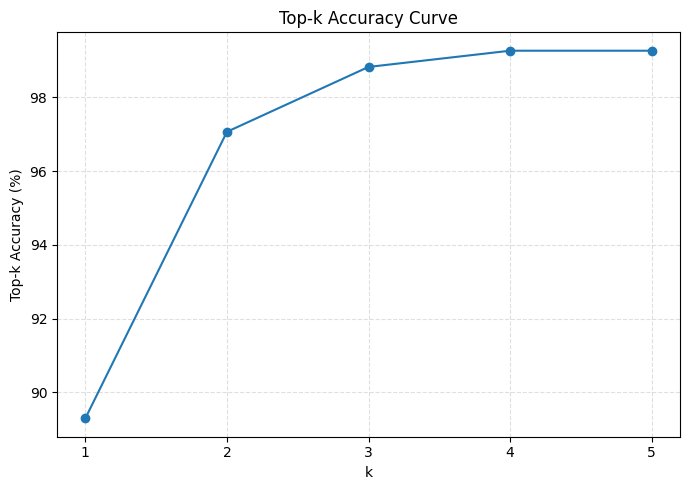

In [64]:
def topk_curve(y_true, y_prob, max_k=5):
    # For each sample, argsort class scores descending → indices of classes by rank
    order = np.argsort(y_prob, axis=1)[:, ::-1]

    ks, vals = [], []
    # Ensure we don't ask for k larger than the number of classes
    for k in range(1, min(max_k, y_prob.shape[1]) + 1):
        # Take the top-k class indices per sample
        topk = order[:, :k]

        # True if the ground-truth class id is in the top-k set for that sample
        acc = np.mean([yt in row for yt, row in zip(y_true, topk)])

        ks.append(k)
        vals.append(acc)

    return np.array(ks), np.array(vals)

# Evaluate and plot Top-k curve (k = 1..5 by default)
ks, vals = topk_curve(y_true, y_prob, max_k=5)

plt.figure(figsize=(7, 5))
# Multiply by 100 to show percentages on the y-axis
plt.plot(ks, vals * 100, marker='o')
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("Top-k Accuracy (%)")
plt.title("Top-k Accuracy Curve")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



In [49]:
# Number of correctly classified samples for each class (diagonal of confusion matrix)
# cm is CxC with rows = true classes and cols = predicted classes.
correct_per_class = np.diag(cm)


Top 10 most correctly predicted classes

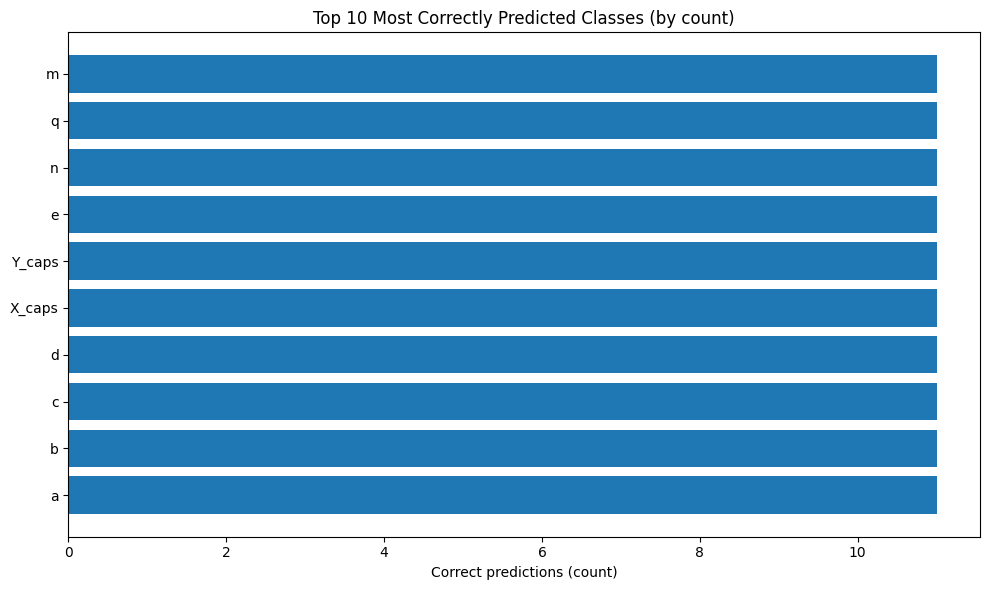

In [65]:
# Rank classes by how many times they were predicted correctly (descending)
order_desc = np.argsort(correct_per_class)[::-1]

# Limit to the top-K classes to keep the chart readable (default K=10 or fewer if C<10)
top_k = min(10, n_classes)
top_idx = order_desc[:top_k]

# Map indices → human-friendly labels and grab their correct counts
top_labels = [class_names[i] for i in top_idx]
top_counts = correct_per_class[top_idx]

# ----- 4) Plot -----
plt.figure(figsize=(10, 6))
# barh plots from bottom to top; reverse arrays so the largest bar appears at the top
bars = plt.barh(top_labels[::-1], top_counts[::-1])
plt.xlabel("Correct predictions (count)")
plt.title("Top 10 Most Correctly Predicted Classes (by count)")
plt.tight_layout()


Top 10 worst predicted classes

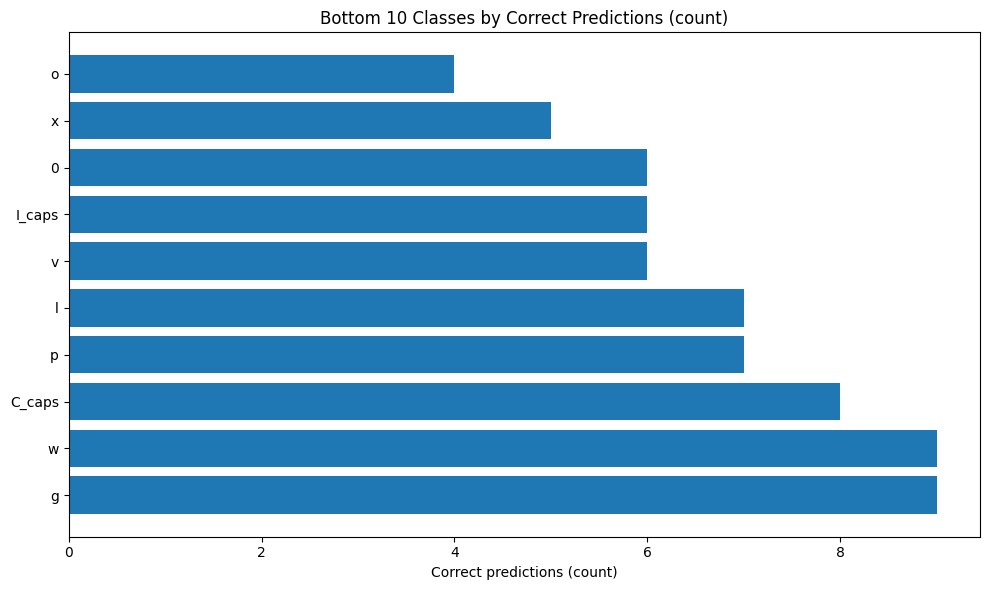

In [66]:
# Rank classes by fewest correct predictions (ascending: hardest/weakest first)
order_asc = np.argsort(correct_per_class)            # smallest counts first

# Limit to bottom-K classes (default K=10 or fewer if C<10)
bottom_k = min(10, n_classes)
bot_idx = order_asc[:bottom_k]

# Map indices → labels and extract their correct counts
bot_labels = [class_names[i] for i in bot_idx]
bot_counts = correct_per_class[bot_idx]

# Plot: reverse so the "worst" class appears at the top of the chart
plt.figure(figsize=(10, 6))
bars = plt.barh(bot_labels[::-1], bot_counts[::-1])  # show worst at top
plt.xlabel("Correct predictions (count)")
plt.title("Bottom 10 Classes by Correct Predictions (count)")
plt.tight_layout()


Compare training and testing performance

In [69]:
import glob, os
# --- Ensure we have a model: prefer in-memory 'best_model', else load from Drive ---
def load_any_model():
    g = globals()
    if 'best_model' in g and g['best_model'] is not None:
        print("Using in-memory best_model.")
        return g['best_model']

    # Try common saved filenames under your PROJECT_ROOT (recursive search).
    # Add patterns here if you save with a different name.
    candidates = []
    for pat in ["**/best_model.keras", "**/*.keras"]:
        candidates += glob.glob(str(PROJECT_ROOT / pat), recursive=True)

    if not candidates:
        # No in-memory model and nothing on disk → fail with a helpful error.
        raise NameError("No model in memory and no saved model found under your 'lo' folder.")

    # Pick the most recently modified file (assumes newer = better/latest run).
    candidates = sorted(candidates, key=lambda p: os.path.getmtime(p), reverse=True)
    path = candidates[0]
    print("Loading saved model:", path)
    mdl = tf.keras.models.load_model(path)
    return mdl

model = load_any_model()

# --- Evaluation helpers (robust to TF tensors) ---
def _collect(model, ds, n_classes):
    y_true, y_prob = [], []
    for xb, yb in ds:
        pb = model.predict(xb, verbose=0)                     # [B, C] or [B] for binary

        # --- Normalize predictions to probabilities --------------------------------
        if pb.ndim == 1:                                      # binary → make 2-class prob
            pb = np.stack([1.0 - pb, pb], axis=1)
        elif pb.shape[-1] != n_classes:                       # if shape mismatches, treat as logits
            pb = tf.nn.softmax(pb, axis=-1).numpy()

        y_prob.append(pb)

        # --- Normalize labels to integer ids ---------------------------------------
        # One-hot with last dim > 1 → argmax; otherwise assume sparse ints.
        if len(yb.shape) > 1 and yb.shape[-1] > 1:            # one-hot
            y_true.append(tf.argmax(yb, axis=1).numpy())
        else:                                                 # sparse (possibly shape [B,1])
            y_true.append(yb.numpy())

    # Concatenate across batches: labels as 1D, probabilities stacked along first axis.
    return np.concatenate(y_true), np.vstack(y_prob)

def eval_split(name, model, ds):
    # Peek one batch to infer n_classes and label format.
    xb0, yb0 = next(iter(ds))
    if len(yb0.shape) > 1 and yb0.shape[-1] > 1:              # one-hot
        n_classes = int(yb0.shape[-1])
    else:                                                     # sparse: try class_names, else max+1
        n_classes = (len(getattr(ds, 'class_names', []))
                     or int(np.max(yb0.numpy()) + 1))

    # Collect predictions/probabilities/labels over the full dataset
    y_true, y_prob = _collect(model, ds, n_classes)
    y_pred = y_prob.argmax(axis=1)

    # Basic metrics for quick comparison; macro-F1 treats all classes equally
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(f"[{name}] accuracy={acc:.4f}  macroF1={macro_f1:.4f}  n={len(y_true)}")

    return {
        "split": name,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

results = []

# --- Use dataset if available; else fall back to history.json summary ---
# Guard access to globals so missing variables don't crash the script.
train_used_ds = globals().get('train_used_ds', None)  # <-- FIX: guard the variable
hist = globals().get('hist', None)                    # may have been loaded earlier

if train_used_ds is not None:
    # Evaluate on the exact dataset used during training (if you cached it).
    results.append(eval_split("train_used", model, train_used_ds))
else:
    # If we don't have train_used_ds, surface a summary from history.json if available.
    if isinstance(hist, dict) and len(hist) > 0:
        def pick(*keys):
            for k in keys:
                if k in hist: return hist[k]
            return None

        # Fetch last training accuracy and best validation accuracy (if present).
        tr_list = pick("accuracy","acc","binary_accuracy","sparse_categorical_accuracy") or []
        va_list = pick("val_accuracy","val_acc","val_binary_accuracy","val_sparse_categorical_accuracy") or []
        train_acc_last = tr_list[-1] if len(tr_list) else None
        val_acc_best   = max(va_list) if len(va_list) else None

        print(f"[train_used(history.json)] train_acc≈{train_acc_last}, best_val_acc≈{val_acc_best}")
        results.append({"split": "train_used(history.json)", "accuracy": train_acc_last, "macro_f1": None})
    else:
        print("No train-used dataset AND no 'hist' JSON available to summarise training.")

# --- Evaluate on TEST (must exist) ---
test_ds = globals().get('test_ds', None)  # <-- guard to provide a clearer error
if test_ds is None:
    # Make the failure actionable: user should recreate test_ds as before (shuffle=False).
    raise NameError("`test_ds` is not defined. Recreate it as you did before (shuffle=False).")

results.append(eval_split("test", model, test_ds))

# --- Summary table ---
# Build a compact comparison table and show accuracy gaps vs test for context.
acc_test = results[-1]["accuracy"]
df = pd.DataFrame([
    {"split": r["split"], "accuracy": r["accuracy"], "macro_f1": r["macro_f1"]}
    for r in results
])
df["acc_gap_vs_test"] = df["accuracy"].apply(lambda x: (x - acc_test) if x is not None else None)

print("\n=== Train vs Test summary ===")
print(df.to_string(index=False))


Loading saved model: /content/drive/MyDrive/lo/models/best_model.keras
[train_used(history.json)] train_acc≈0.9417155385017395, best_val_acc≈0.9233871102333069
[test] accuracy=0.8930  macroF1=0.8917  n=682

=== Train vs Test summary ===
                   split  accuracy  macro_f1  acc_gap_vs_test
train_used(history.json)  0.941716       NaN         0.048754
                    test  0.892962   0.89168         0.000000
